# Transfer Learning en CNNs

## Carga de VGG
Keras dispone de un módulo llamado [`applications`](https://keras.io/applications/) que nos permiter realizar la importación de modelos conocidos (VGG16 entre ellos), seleccionando los pesos que queremos importar en función de sobre qué dataset haya sido entrenado.

Importamos  el modelo [VGG16](https://neurohive.io/en/popular-networks/vgg16/) que hemos visto en las transparencias. VGG16 es una red convolucional entrenada sobre el dataset [ImageNet](http://www.image-net.org/), muy utilizado para la investigación y el desarrollo de nuevas redes neuronales convolucionales.

Se pueden ver las clases que incluye ImageNet [aquí](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [17]:
from keras import applications

Cuando importamos el modelo, además especificamos que no queremos que el modelo sea entrenable, que quiere decir que los pesos (filtros) que estamos importando no van a ser alterados durante el proceso de entrenamiento de la nueva red que vamos a hacer basándonos en ésta:

In [18]:
# build the VGG16 network
pretrained_model = applications.VGG16(input_shape=(224,224,3),
                            include_top=False, # Indica que no queremos las capas densas arriba (al final) del modelo
                            weights='imagenet') # Queremos los pesos (filtros) entrenados para ImageNet
pretrained_model.trainable=False

Le pedimos a Keras un resumen del modelo importado:

In [19]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
for layer in pretrained_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


Al importar VGG16, podemos ver que sólo nos hemos traído las capas convolucionales y de max pooling, dejando atrás efectivamente las capas densas al final del modelo. Esto nos permitirá conectar nuestras propias capas densas para nuestro entrenamiento sobre ellas y realizar predicciones sobre un dataset que el modelo aún no ha visto.

Mostramos las dimensiones de los pesos de la primera capa, y comprobamos que efectivamente tenemos 64 filtros de dimensión 3x3:

In [21]:
vgg_weights, vgg_biases = pretrained_model.layers[1].get_weights()
vgg_weights.shape

(3, 3, 3, 64)

## Importación de imágenes desde Flickr

Ahora escribimos código para importar un conjunto de imágenes de serpientes desde el servicio de imágenes [Flickr](https://www.flickr.com).

Lo primero es configurar la autenticación del API de Flickr para hacer la descarga de las imágenes:

In [22]:
! pip install -q flickrapi

In [23]:
import flickrapi
import json


api_key = u'f770a9e7064fa7f8754b1ed8cc8cda4f'
api_secret = u' 2e750f2d723350c8 '

import flickrapi
flickr = flickrapi.FlickrAPI(api_key, api_secret, format='json')

Definimos una función que, dado un ID de imagen de Flickr, nos devuelve una URL que podemos consumir desde el cuaderno:

In [24]:
def get_url(photo_id="6532032747"):
    response = flickr.photos.getsizes(photo_id=photo_id)
    sizes = json.loads(response.decode('utf-8'))['sizes']['size']
    for size in sizes:
        if size['label'] == "Small":
            return size['source']
            
get_url()

'https://live.staticflickr.com/7009/6532032747_41e8789639_m.jpg'

Probamos a mostrar la URL que nos devuelve la función anterior con el ID que tiene configurado por defecto, para comprobar que todo funciona bien:

In [25]:
from IPython.display import HTML
HTML("<img src='https://live.staticflickr.com/7009/6532032747_41e8789639_m.jpg'>")

Definimos una función de búsqueda de IDs de imágenes en Flickr basándonos en una cadena de texto que busca por defecto 10 serpientes pitón por defecto y que devuelve los IDs en una lista:

In [26]:
def search_ids(search_string="python", per_page=10):
    photos_response = flickr.photos.search(text=search_string, per_page=per_page, sort='relevance')
    photos = json.loads(photos_response.decode('utf-8'))['photos']['photo']
    ids = [photo['id'] for photo in photos]
    return ids

La función `search_ids` definida anteriormente admite parámetros, así que buscamos 100 resultados de `ball snake` (un tipo particular de serpiente pitón que no está en ImageNet:

In [27]:
ids = search_ids("ball snake", per_page=100)
urls_ball = [get_url(photo_id=i) for i in ids]
img_string = "\n".join(["<img src='{}'>".format(url) for url in urls_ball])
HTML(img_string)

Buscamos también otros 100 resultados de `carpet python` (otro tipo particular de serpiente pitón que tampoco se encuentra como clase en ImageNet):

In [28]:
ids = search_ids("carpet python", per_page=100)
urls_carpet = [get_url(photo_id=i) for i in ids]
img_string = "\n".join(["<img src='{}'>".format(url) for url in urls_carpet])
HTML(img_string)

Ahora creamos un directorio en el sistema de ficheros local con el nombre de cada clase para almacenar las imágenes ahí: 

In [29]:
!mkdir -p snakes/carpet
!mkdir snakes/ball

mkdir: cannot create directory ‘snakes/ball’: File exists


Descargamos las imágenes de los dos tipos de serpientes en nuestras carpetas:

In [30]:
from urllib.request import urlretrieve
import os
for url in urls_carpet:
    urlretrieve(url, os.path.join("snakes", "carpet", os.path.basename(url)))


In [31]:
for url in urls_ball:
    urlretrieve(url, os.path.join("snakes", "ball", os.path.basename(url)))

Importamos ahora la clase `image` del módulo `preprocessing` para cargar las imágenes de las carpetas e poder almacenarlas en un array X que contenga la muestras:

In [32]:
from keras.preprocessing import image
import numpy as np

images_carpet = [image.load_img(os.path.join("snakes", "carpet", os.path.basename(url)), target_size=(224, 224))
                 for url in urls_carpet]
images_ball = [image.load_img(os.path.join("snakes", "ball", os.path.basename(url)), target_size=(224, 224))
                 for url in urls_ball]
X = np.array([image.img_to_array(img) for img in images_carpet + images_ball])

El vector que estamos esperando debería almacenar 200 imágenes de 224x224 con tres canales:

In [33]:
X.shape

(200, 224, 224, 3)

Mostramos las imágenes de la clase carpet python:

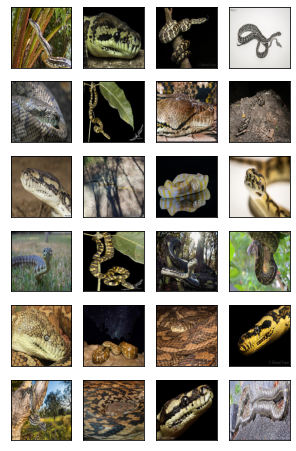

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 4, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(5, 8))
for img, ax in zip(images_carpet, axes.ravel()):
    ax.imshow(img)

Mostramos las imágenes de la clase ball snake:

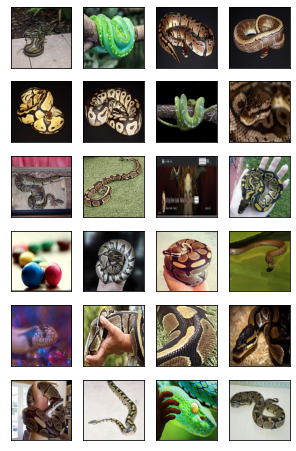

In [35]:
fig, axes = plt.subplots(6, 4, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(5, 8))
for img, ax in zip(images_ball, axes.ravel()):
    ax.imshow(img)

Ahora creamos un vector de etiquetas para poder realizar el entrenamiento:

## Preparación de los datos de entrada y etiquetas

In [49]:
y = np.zeros(200, dtype='int')
y[100:] = 1
y.shape

(200,)

Utilizamos el método `preprocess_input` de VGG16 para adecuar nuestras imágenes al formato que el modelo requiere:

In [37]:
from keras.applications.vgg16 import preprocess_input
X_pre = preprocess_input(X)

Hacemos un split de los datos en los conjuntos de entrenamiento y validación

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, stratify=y)

In [39]:
X_train.shape

(150, 224, 224, 3)

In [51]:
y_train.shape

(150,)

## Configuración y entrenamiento de una nueva red neuronal

Es el momento de ampliar la red neuronal para incluir una capa densa de clasificación que nos diga qué tipo de serpiente es la imagen de entrada:

In [81]:
from keras.applications.vgg16 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense

new_model = Sequential([
  pretrained_model,
  Flatten(),
  Dense(128),
  Dense(1, activation='sigmoid')  # Sigmoid es como un caso especial de softmax que nos viene bien si tenemos sólo una neurona de salida
])

Compilamos nuestro modelo:

In [82]:
new_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [83]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


Como puede verse, tenemos 14 millones de parámetros de los cuales sólo hay que entrenar 25000.

Entrenamos el modelo, y usamos un callback para guardar los datos que después pondremos en un gráfico:

In [84]:
history = new_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_split=.1
)

Train on 135 samples, validate on 15 samples
Epoch 1/10
135/135 [==============================] - 1s 4ms/step - loss: 12.6268 - accuracy: 0.5259 - val_loss: 74.6903 - val_accuracy: 0.7333
Epoch 2/10
135/135 [==============================] - 0s 3ms/step - loss: 24.1606 - accuracy: 0.8370 - val_loss: 81.9522 - val_accuracy: 0.7333
Epoch 3/10
135/135 [==============================] - 0s 3ms/step - loss: 83.2681 - accuracy: 0.7481 - val_loss: 43.5433 - val_accuracy: 0.8000
Epoch 4/10
135/135 [==============================] - 0s 3ms/step - loss: 10.2554 - accuracy: 0.9333 - val_loss: 84.9477 - val_accuracy: 0.8000
Epoch 5/10
135/135 [==============================] - 0s 3ms/step - loss: 2.1158 - accuracy: 0.9704 - val_loss: 149.2723 - val_accuracy: 0.7333
Epoch 6/10
135/135 [==============================] - 0s 3ms/step - loss: 9.0364 - accuracy: 0.9481 - val_loss: 160.8085 - val_accuracy: 0.7333
Epoch 7/10
135/135 [==============================] - 0s 3ms/step - loss: 2.4437 - accuracy

## Extracción y reuso de features en un clasificador logístico

Ahora vamos, sin ampliar la red, a extraer las features y usarlas como entrada para el entrenamiento de un clasificador logístico. 

In [86]:
features = pretrained_model.predict(X_pre)

In [87]:
features.shape

(200, 7, 7, 512)

Para poder utilizar las features en un regresor logístico, vamos a reconvertirlo a un tensor 2D:

In [88]:
features_ = features.reshape(200, -1)

In [89]:
features_.shape

(200, 25088)

Volvemos a definir nuestros conjuntos de entrenamiento y test:

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_, y, stratify=y)

Importamos un modelo de regresión logística para clasificación de Scikit-Learn y lo entrenamos:

In [95]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV().fit(X_train, y_train)

In [92]:
print(lr.score(X_train, y_train))

1.0


In [93]:
print(lr.score(X_test, y_test))

0.9


Finalmente, vemos el resultado de la clasificación sobre el conjunto de test. Considerando que el dataset original no era 100 limpio, y que es muy pequeño, los resultados no están del todo mal:

In [96]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lr.predict(X_test))

array([[24,  1],
       [ 4, 21]])